Preprocessing using scvelo environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from to_velocity import pseudotime_to_velocity

#import scanpy as sc
import scvelo as scv

In [3]:
path = './beeline_data/curated/VSC-2000-1/'

In [4]:
gem = pd.read_csv(path + 'ExpressionData.csv', index_col = 0)
pseudotime = pd.read_csv(path + 'PseudoTime.csv', index_col = 0) #is distributed in 5 columns, we need to make it one
pseudotime_all = pd.DataFrame({'pseudotime': pseudotime.fillna(0).sum(axis=1)})
ref = pd.read_csv(path + 'refNetwork.csv') #ground truth

In [5]:
#save information into adata
adata = anndata.AnnData(X=gem.T)
adata.obs = pseudotime_all
adata.uns['ref'] = ref
adata

AnnData object with n_obs × n_vars = 2000 × 8
    obs: 'pseudotime'
    uns: 'ref'

In [6]:
scv.pp.neighbors(adata)

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


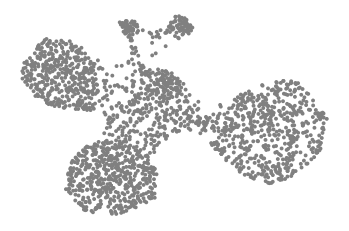

In [7]:
scv.tl.umap(adata)
scv.pl.umap(adata)

In [8]:
scv.pp.pca(adata)

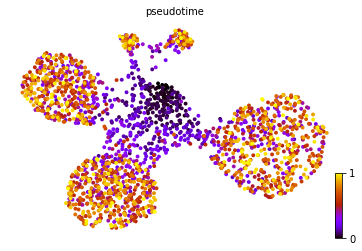

In [10]:
scv.pl.scatter(adata, color='pseudotime', cmap='gnuplot')

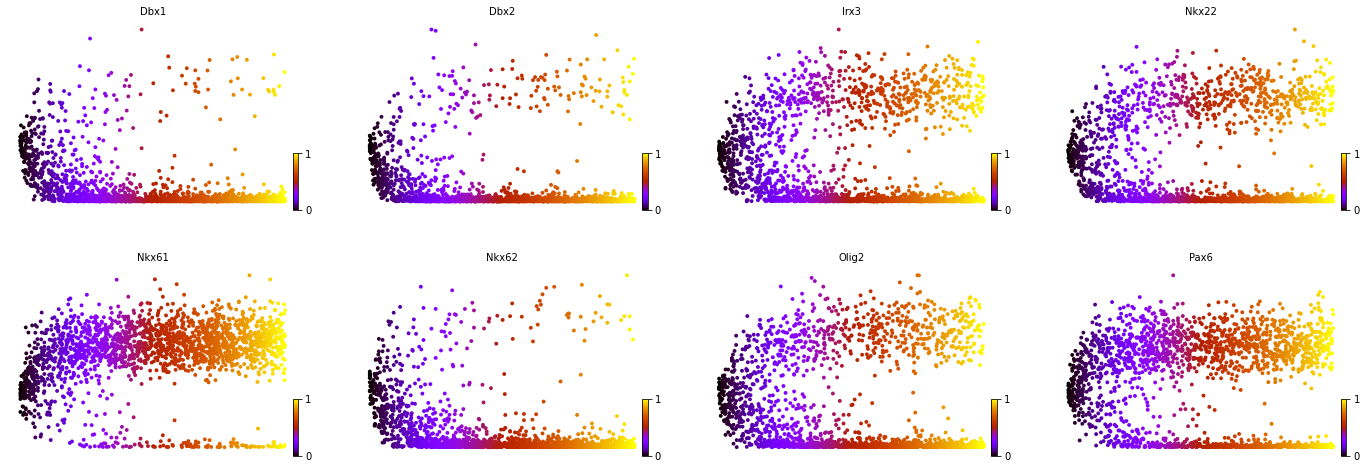

In [95]:
#Expression through time
var_names = list(adata.to_df().columns.values)
scv.pl.scatter(adata, x='pseudotime', color='pseudotime', y=var_names, ncols=4, cmap='gnuplot', frameon=False)

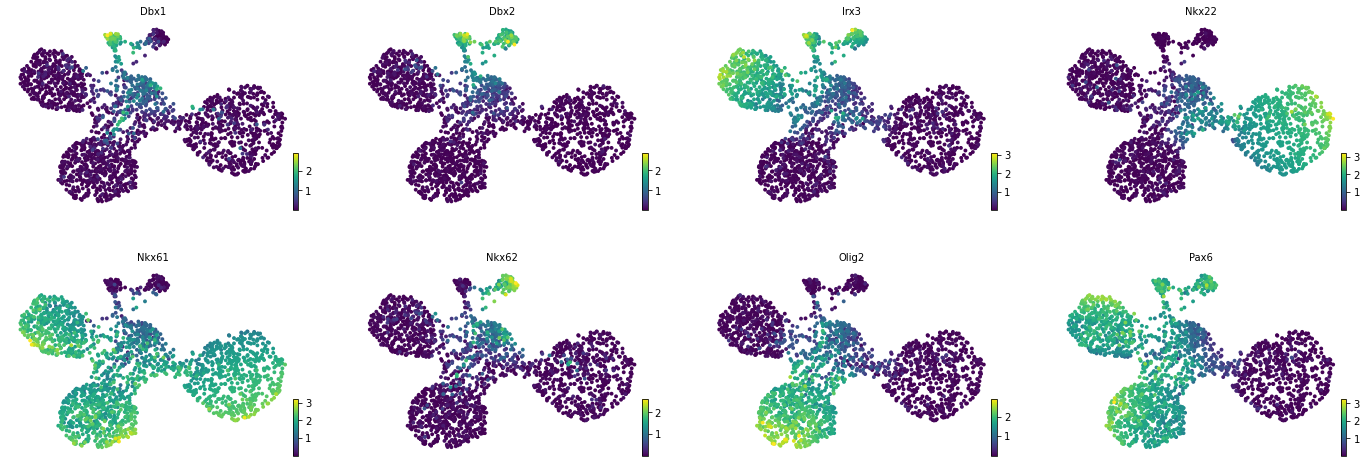

In [25]:
scv.pl.scatter(adata, color=var_names, ncols=4)

We need that the samples are possible trajectories, not just a random subset. Otherwise, we will have situations like the plots above, where the genes show different expression patterns in similar times. This is because we need to somehow differentiate the type of cells or give plaussible trajectories with expression patterns that make sense.

In [20]:
#estimate a naive velocity from pseudotime
pseudotime_to_velocity(adata)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


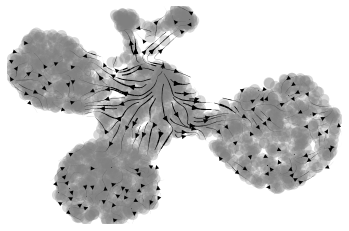

In [21]:
#velocity plot
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Sampling Random Walks

In [87]:
#100 starting points
num_walks = 100
random_choice = np.random.choice(adata.shape[0], num_walks, replace=False)

In [89]:
gem={}
for i in np.arange(num_walks):
    cells = scv.utils.get_cell_transitions(adata, starting_cell=random_choice[i])
    bool_var = np.isin(np.arange(2000), cells)
    gem[i] = adata[bool_var].to_df()

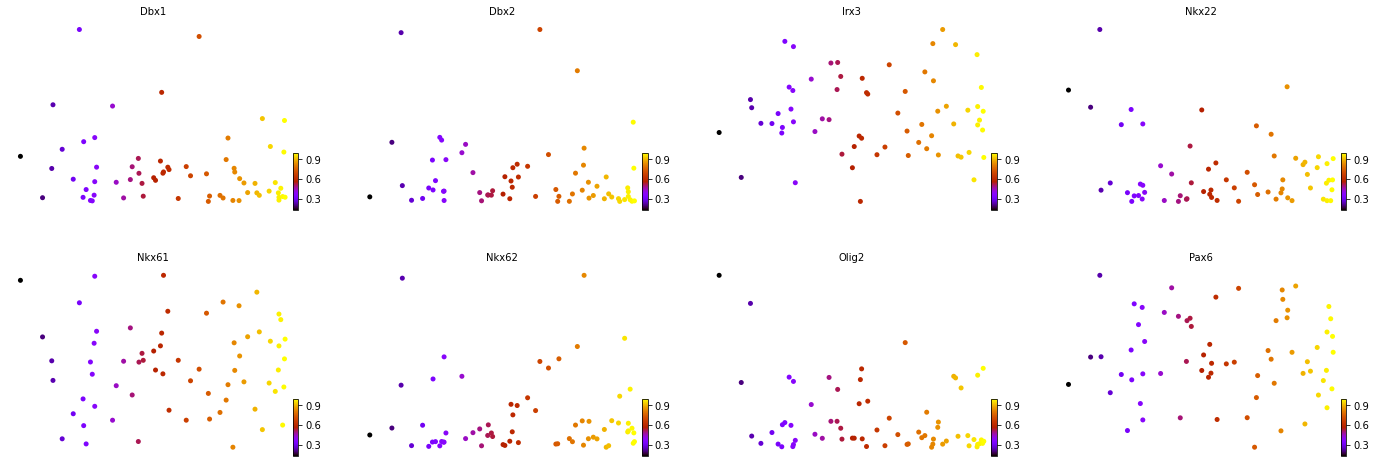

In [113]:
var_names = list(adata.to_df().columns.values)
scv.pl.scatter(adata[bool_var], x='pseudotime', color='pseudotime', y=var_names, ncols=4, cmap='gnuplot', frameon=False, size=100)

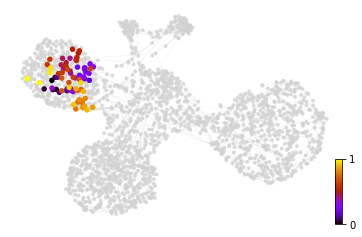

In [45]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=174)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)